In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
# from IPython.display import clear_output
import os
import random
from tqdm.auto import tqdm
from timeit import default_timer as timer

import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
# import keras.engine as KE
import keras.models as KM
from tensorflow.keras.initializers import GlorotNormal

print("TensorFlow version:", tf.__version__)

Mounted at /content/drive
TensorFlow version: 2.13.0


In [2]:
!pip install wandb
import wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=08b1c80ba49ebe9219be5cb3ab759fb8fd4db5a629ac81e4a302e3bcec2e64d4
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import sys
sys.path.append('/content/drive/My Drive/kaggle/contrail_detector/')
import utils
import models
from configs import wnet_unet_config, Path


# 1. Training the Model

In [4]:
train_metadata = pd.read_json("/content/drive/MyDrive/kaggle/contrail_detector/data/train_metadata.json", dtype={'record_id': 'str'})
valid_metadata = pd.read_json("/content/drive/MyDrive/kaggle/contrail_detector/data/valid_metadata.json", dtype={'record_id': 'str'})

In [5]:
def load_data(record_id, path):
    # make path objects
    record_id = record_id.numpy().decode('utf-8')
    path = path.numpy().decode('utf-8')
    image_path = path + "masked_image/" + str(record_id) + ".npy"
    mask_path = path + "mask/" + str(record_id) + ".npy"
    # load the images and masks for the correspoding paths
    image = np.load(image_path)[...,wnet_unet_config.n_times_before, :].astype(np.float32)
    mask = np.load(mask_path).astype(np.float32)
    return image, mask

def augment_data(image, mask):
    # random flip
    image_mask_concat = tf.concat([image, mask], axis = -1)
    image_mask_concat = tf.image.random_flip_left_right(image_mask_concat)
    image_mask_concat = tf.image.random_flip_up_down(image_mask_concat)
    # random crop
    cropped = tf.image.random_crop(image_mask_concat, size=[(wnet_unet_config.image_shape[0]*3)//4,(wnet_unet_config.image_shape[1]*3)//4, 4])
    image_mask_concat = tf.image.resize(cropped, [wnet_unet_config.image_shape[0], wnet_unet_config.image_shape[1]])

    image = image_mask_concat[..., :-1]
    mask = image_mask_concat[..., -1]
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.cast(mask > 0.5, tf.float32)
    return image, mask

In [6]:
id_to_data = lambda record_id, path : tf.py_function(func = load_data, inp = [record_id, path], Tout = (tf.float32, tf.float32))
train_id = train_metadata.record_id.to_list()
valid_id = valid_metadata.record_id.to_list()

train_path = len(train_id)*[Path.train]
valid_path = len(valid_id)*[Path.valid]

train_id_dataset = tf.data.Dataset.from_tensor_slices(train_id)
train_path_dataset = tf.data.Dataset.from_tensor_slices(train_path)

valid_id_dataset = tf.data.Dataset.from_tensor_slices(valid_id)
valid_path_dataset = tf.data.Dataset.from_tensor_slices(valid_path)

train_dataset = tf.data.Dataset.zip((train_id_dataset, train_path_dataset)).map(id_to_data).map(augment_data).shuffle(wnet_unet_config.buffer_size).batch(wnet_unet_config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = tf.data.Dataset.zip((valid_id_dataset, valid_path_dataset)).map(id_to_data).shuffle(wnet_unet_config.buffer_size).batch(wnet_unet_config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)




In [7]:
len(train_id), len(valid_id)

(400, 100)

In [8]:
def dice_score(y_true, y_pred, thr=0.5, epsilon=1e-6):
    # Thresholding predictions
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred = tf.cast(y_pred > thr, tf.float32)

    # Flattening tensors
    y_true = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    # Computing intersections and unions
    intersections = tf.reduce_sum(y_true * y_pred, axis=1)
    unions = tf.reduce_sum(y_true, axis=1) + tf.reduce_sum(y_pred, axis=1)

    # Computing Dice scores
    dices = (2. * intersections + epsilon) / (unions + epsilon)

    return tf.reduce_mean(dices)

# Define Dice Loss
# we do not binarize the prediction for dice 'loss' calculation
def dice_loss(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return tf.reduce_mean(1 - (numerator + epsilon) / (denominator + epsilon))

# Binary Cross Entropy Loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)

# Combined Loss
def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    return alpha * bce(y_true, y_pred) + beta * dice_loss(y_true, y_pred)

In [9]:
@tf.function
def train_step(inputs, labels, model, loss_fn, optimizer):
  with tf.GradientTape() as tape:
    predictions = model(inputs, training = True)[...,-1:]
    loss_value = loss_fn(labels, predictions)
  gradients = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss_value

@tf.function
def valid_step(inputs, labels, model, loss_fn, metric_fn):
  predictions = model(inputs, training = False)[...,-1:]
  loss_value = loss_fn(labels, predictions)
  metric_value = metric_fn(labels, predictions, thr = 0.5)
  return loss_value, metric_value

def train_model(train_dataset, valid_dataset, model, loss_fn, metric_fn, optimizer, epochs, checkpoint_directory, log_directory, resume = None, max_to_keep=3):

  # printout which device the model is on
  print(model.layers[0].weights[0].device)

  train_losses = []
  valid_losses = []
  valid_metrics = []

  # Create a checkpoint object and checkpoint manager
  checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                   optimizer=optimizer,
                                   model=model)
  manager = tf.train.CheckpointManager(checkpoint,
                                       checkpoint_directory,
                                       max_to_keep)

  # restore the last checkpoint if there is one
  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  train_summary_writer = tf.summary.create_file_writer(log_directory)
  valid_summary_writer = tf.summary.create_file_writer(log_directory)

  # Initialize W&B run
  wandb.init(project='contrail_detector', name='wnet_unet', resume = resume)


  # training loop starts
  for epoch in range(epochs):
    start_time = timer()
    checkpoint.step.assign_add(1)
    print(f"\n Epoch {checkpoint.step.numpy()} : \n")

    # initialize losses and metrics
    train_total_loss = 0
    valid_total_loss = 0
    valid_total_metric = 0
    train_n_batches = 0
    valid_n_batches = 0

    # train loop
    for step, (X_batch, y_batch) in enumerate(tqdm(train_dataset, desc='Training', position=0)):
      loss_value = train_step(X_batch, y_batch, model, loss_fn, optimizer)

      train_total_loss += loss_value
      train_n_batches += 1

      if step % 1 == 0: # print every 1 batches
        print(f"batch {step}, train_loss: {loss_value:.4f}")

    # valid loop
    for step, (X_batch, y_batch) in enumerate(tqdm(valid_dataset, desc='Validation', position=0)):
      loss_value, metric_value = valid_step(X_batch, y_batch, model, loss_fn, metric_fn)
      valid_total_loss += loss_value
      valid_total_metric += metric_value
      valid_n_batches += 1

    train_epoch_loss = train_total_loss / train_n_batches
    valid_epoch_loss = valid_total_loss / valid_n_batches
    valid_epoch_metric = valid_total_metric / valid_n_batches

    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)
    valid_metrics.append(valid_epoch_metric)

    # Log training metrics for the epoch
    with train_summary_writer.as_default():
        tf.summary.scalar('train_loss', train_epoch_loss, step=checkpoint.step.numpy())

    # Log validation metrics for the epoch
    with valid_summary_writer.as_default():
        tf.summary.scalar('valid_loss', valid_epoch_loss, step=checkpoint.step.numpy())
        tf.summary.scalar('valid_metric', valid_epoch_metric, step=checkpoint.step.numpy())

    # Log metrics to W&B
    wandb.log({
              'train_loss': train_epoch_loss.numpy(),
              'valid_loss': valid_epoch_loss.numpy(),
              'valid_metric': valid_epoch_metric.numpy(),
              'epoch': checkpoint.step.numpy()
          })
    #save checkpoint
    save_path = manager.save()

    # Save checkpoint to W&B as an artifact
    artifact = wandb.Artifact(f'wnet_unet-epoch-{checkpoint.step.numpy()}-checkpoint', type='model')
    # Add the index file
    artifact.add_file(save_path + ".index")

    # Add the data file
    artifact.add_file(save_path + ".data-00000-of-00001")

    wandb.log_artifact(artifact)
    end_time = timer()

    # print out results
    print("\n")
    print("  (Results)")
    print(f"  train_loss: {train_epoch_loss:.4f}")
    print(f"  valid_loss: {valid_epoch_loss:.4f}")
    print(f"  valid_metric: {valid_epoch_metric:.4f}")
    print("\n")
    print("  (Time)")
    print("  start_time : ", start_time)
    print("  end_time : ", end_time)
    print("-----------------------------------------------------------------")

  # Finish the W&B run
  wandb.finish()

  return train_losses, valid_losses, valid_metrics

In [10]:
model = models.unet()
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(wnet_unet_config.initial_learning_rate,
                                                        decay_steps=wnet_unet_config.decay_steps,
                                                        alpha=wnet_unet_config.alpha)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
loss_fn = lambda labels, predictions : dice_loss(labels, predictions)
metric_fn = lambda labels, predictions,thr : dice_score(labels, predictions, thr)

In [11]:
checkpoint_directory = "/content/drive/MyDrive/kaggle/contrail_detector/checkpoint/wnet_unet"
log_directory = "/content/drive/MyDrive/kaggle/contrail_detector/log/wnet_unet"
train_losses, valid_losses, valid_metrics = train_model(train_dataset, valid_dataset, model,
                                                        loss_fn, metric_fn, optimizer,
                                                        epochs=wnet_unet_config.n_epochs,
                                                        checkpoint_directory = checkpoint_directory,
                                                        log_directory = log_directory,
                                                        resume = None)

/job:localhost/replica:0/task:0/device:GPU:0
Initializing from scratch.


wandb: Currently logged in as: jun23ird. Use `wandb login --relogin` to force relogin



 Epoch 1 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9996
batch 1, train_loss: 0.9941
batch 2, train_loss: 0.9971
batch 3, train_loss: 0.9972
batch 4, train_loss: 0.9921
batch 5, train_loss: 0.9928
batch 6, train_loss: 0.9910
batch 7, train_loss: 0.9958
batch 8, train_loss: 0.9948
batch 9, train_loss: 0.9923
batch 10, train_loss: 0.9968
batch 11, train_loss: 0.9949
batch 12, train_loss: 0.9972
batch 13, train_loss: 0.9904
batch 14, train_loss: 0.9969
batch 15, train_loss: 0.9943
batch 16, train_loss: 0.9903
batch 17, train_loss: 0.9969
batch 18, train_loss: 0.9945
batch 19, train_loss: 0.9940


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1049.381487819
  end_time :  1791.092731744
-----------------------------------------------------------------

 Epoch 2 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9976
batch 1, train_loss: 0.9928
batch 2, train_loss: 0.9970
batch 3, train_loss: 0.9978
batch 4, train_loss: 0.9922
batch 5, train_loss: 0.9932
batch 6, train_loss: 0.9931
batch 7, train_loss: 0.9949
batch 8, train_loss: 0.9948
batch 9, train_loss: 0.9981
batch 10, train_loss: 0.9942
batch 11, train_loss: 0.9922
batch 12, train_loss: 0.9950
batch 13, train_loss: 0.9962
batch 14, train_loss: 0.9949
batch 15, train_loss: 0.9902
batch 16, train_loss: 0.9943
batch 17, train_loss: 0.9968
batch 18, train_loss: 0.9958
batch 19, train_loss: 0.9943


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9948
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1791.098680149
  end_time :  1804.884210847
-----------------------------------------------------------------

 Epoch 3 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9930
batch 1, train_loss: 0.9978
batch 2, train_loss: 0.9964
batch 3, train_loss: 0.9990
batch 4, train_loss: 0.9901
batch 5, train_loss: 0.9916
batch 6, train_loss: 0.9928
batch 7, train_loss: 0.9967
batch 8, train_loss: 0.9935
batch 9, train_loss: 0.9938
batch 10, train_loss: 0.9975
batch 11, train_loss: 0.9950
batch 12, train_loss: 0.9957
batch 13, train_loss: 0.9939
batch 14, train_loss: 0.9958
batch 15, train_loss: 0.9916
batch 16, train_loss: 0.9915
batch 17, train_loss: 0.9952
batch 18, train_loss: 0.9933
batch 19, train_loss: 0.9974


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1804.890460021
  end_time :  1818.393511023
-----------------------------------------------------------------

 Epoch 4 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9931
batch 1, train_loss: 0.9973
batch 2, train_loss: 0.9976
batch 3, train_loss: 0.9975
batch 4, train_loss: 0.9883
batch 5, train_loss: 0.9967
batch 6, train_loss: 0.9908
batch 7, train_loss: 0.9978
batch 8, train_loss: 0.9921
batch 9, train_loss: 0.9979
batch 10, train_loss: 0.9969
batch 11, train_loss: 0.9901
batch 12, train_loss: 0.9974
batch 13, train_loss: 0.9956
batch 14, train_loss: 0.9924
batch 15, train_loss: 0.9902
batch 16, train_loss: 0.9911
batch 17, train_loss: 0.9970
batch 18, train_loss: 0.9966
batch 19, train_loss: 0.9948


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1818.398757323
  end_time :  1831.838522984
-----------------------------------------------------------------

 Epoch 5 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9939
batch 1, train_loss: 0.9961
batch 2, train_loss: 0.9967
batch 3, train_loss: 0.9985
batch 4, train_loss: 0.9914
batch 5, train_loss: 0.9877
batch 6, train_loss: 0.9973
batch 7, train_loss: 0.9935
batch 8, train_loss: 0.9957
batch 9, train_loss: 0.9907
batch 10, train_loss: 0.9955
batch 11, train_loss: 0.9968
batch 12, train_loss: 0.9948
batch 13, train_loss: 0.9947
batch 14, train_loss: 0.9916
batch 15, train_loss: 0.9945
batch 16, train_loss: 0.9915
batch 17, train_loss: 0.9945
batch 18, train_loss: 0.9954
batch 19, train_loss: 0.9934


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9942
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1831.84369589
  end_time :  1847.246533631
-----------------------------------------------------------------

 Epoch 6 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9940
batch 1, train_loss: 0.9959
batch 2, train_loss: 0.9971
batch 3, train_loss: 0.9971
batch 4, train_loss: 0.9960
batch 5, train_loss: 0.9896
batch 6, train_loss: 0.9944
batch 7, train_loss: 0.9949
batch 8, train_loss: 0.9953
batch 9, train_loss: 0.9926
batch 10, train_loss: 0.9972
batch 11, train_loss: 0.9961
batch 12, train_loss: 0.9958
batch 13, train_loss: 0.9955
batch 14, train_loss: 0.9915
batch 15, train_loss: 0.9932
batch 16, train_loss: 0.9919
batch 17, train_loss: 0.9974
batch 18, train_loss: 0.9948
batch 19, train_loss: 0.9956


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9948
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1847.252030782
  end_time :  1860.791426105
-----------------------------------------------------------------

 Epoch 7 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9928
batch 1, train_loss: 0.9967
batch 2, train_loss: 0.9984
batch 3, train_loss: 0.9982
batch 4, train_loss: 0.9900
batch 5, train_loss: 0.9891
batch 6, train_loss: 0.9961
batch 7, train_loss: 0.9957
batch 8, train_loss: 0.9930
batch 9, train_loss: 0.9935
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9971
batch 12, train_loss: 0.9955
batch 13, train_loss: 0.9935
batch 14, train_loss: 0.9921
batch 15, train_loss: 0.9937
batch 16, train_loss: 0.9902
batch 17, train_loss: 0.9982
batch 18, train_loss: 0.9940
batch 19, train_loss: 0.9947


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1860.796441924
  end_time :  1874.211091617
-----------------------------------------------------------------

 Epoch 8 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9945
batch 1, train_loss: 0.9961
batch 2, train_loss: 0.9959
batch 3, train_loss: 0.9973
batch 4, train_loss: 0.9883
batch 5, train_loss: 0.9968
batch 6, train_loss: 0.9909
batch 7, train_loss: 0.9952
batch 8, train_loss: 0.9926
batch 9, train_loss: 0.9972
batch 10, train_loss: 0.9929
batch 11, train_loss: 0.9960
batch 12, train_loss: 0.9973
batch 13, train_loss: 0.9898
batch 14, train_loss: 0.9973
batch 15, train_loss: 0.9924
batch 16, train_loss: 0.9907
batch 17, train_loss: 0.9964
batch 18, train_loss: 0.9955
batch 19, train_loss: 0.9963


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1874.216533407
  end_time :  1889.223824906
-----------------------------------------------------------------

 Epoch 9 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9921
batch 1, train_loss: 0.9979
batch 2, train_loss: 0.9971
batch 3, train_loss: 0.9964
batch 4, train_loss: 0.9923
batch 5, train_loss: 0.9928
batch 6, train_loss: 0.9941
batch 7, train_loss: 0.9961
batch 8, train_loss: 0.9968
batch 9, train_loss: 0.9892
batch 10, train_loss: 0.9971
batch 11, train_loss: 0.9963
batch 12, train_loss: 0.9959
batch 13, train_loss: 0.9939
batch 14, train_loss: 0.9959
batch 15, train_loss: 0.9901
batch 16, train_loss: 0.9938
batch 17, train_loss: 0.9986
batch 18, train_loss: 0.9959
batch 19, train_loss: 0.9932


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9948
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1889.232236245
  end_time :  1902.729475387
-----------------------------------------------------------------

 Epoch 10 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9944
batch 1, train_loss: 0.9954
batch 2, train_loss: 0.9970
batch 3, train_loss: 0.9953
batch 4, train_loss: 0.9933
batch 5, train_loss: 0.9921
batch 6, train_loss: 0.9946
batch 7, train_loss: 0.9954
batch 8, train_loss: 0.9961
batch 9, train_loss: 0.9916
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9957
batch 12, train_loss: 0.9961
batch 13, train_loss: 0.9915
batch 14, train_loss: 0.9950
batch 15, train_loss: 0.9916
batch 16, train_loss: 0.9942
batch 17, train_loss: 0.9964
batch 18, train_loss: 0.9961
batch 19, train_loss: 0.9950


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1902.735941737
  end_time :  1918.730272596
-----------------------------------------------------------------

 Epoch 11 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9935
batch 1, train_loss: 0.9957
batch 2, train_loss: 0.9969
batch 3, train_loss: 0.9968
batch 4, train_loss: 0.9887
batch 5, train_loss: 0.9967
batch 6, train_loss: 0.9925
batch 7, train_loss: 0.9944
batch 8, train_loss: 0.9948
batch 9, train_loss: 0.9931
batch 10, train_loss: 0.9957
batch 11, train_loss: 0.9963
batch 12, train_loss: 0.9967
batch 13, train_loss: 0.9956
batch 14, train_loss: 0.9899
batch 15, train_loss: 0.9917
batch 16, train_loss: 0.9939
batch 17, train_loss: 0.9968
batch 18, train_loss: 0.9975
batch 19, train_loss: 0.9936


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1918.735245622
  end_time :  1932.123234814
-----------------------------------------------------------------

 Epoch 12 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9928
batch 1, train_loss: 0.9967
batch 2, train_loss: 0.9986
batch 3, train_loss: 0.9964
batch 4, train_loss: 0.9914
batch 5, train_loss: 0.9896
batch 6, train_loss: 0.9959
batch 7, train_loss: 0.9981
batch 8, train_loss: 0.9945
batch 9, train_loss: 0.9915
batch 10, train_loss: 0.9973
batch 11, train_loss: 0.9960
batch 12, train_loss: 0.9969
batch 13, train_loss: 0.9898
batch 14, train_loss: 0.9982
batch 15, train_loss: 0.9918
batch 16, train_loss: 0.9906
batch 17, train_loss: 0.9974
batch 18, train_loss: 0.9950
batch 19, train_loss: 0.9934


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1932.132536231
  end_time :  1946.477292619
-----------------------------------------------------------------

 Epoch 13 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9923
batch 1, train_loss: 0.9970
batch 2, train_loss: 0.9971
batch 3, train_loss: 0.9977
batch 4, train_loss: 0.9930
batch 5, train_loss: 0.9891
batch 6, train_loss: 0.9943
batch 7, train_loss: 0.9932
batch 8, train_loss: 0.9958
batch 9, train_loss: 0.9939
batch 10, train_loss: 0.9946
batch 11, train_loss: 0.9958
batch 12, train_loss: 0.9956
batch 13, train_loss: 0.9944
batch 14, train_loss: 0.9911
batch 15, train_loss: 0.9940
batch 16, train_loss: 0.9892
batch 17, train_loss: 0.9980
batch 18, train_loss: 0.9957
batch 19, train_loss: 0.9942


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9943
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1946.484230972
  end_time :  1959.988152018
-----------------------------------------------------------------

 Epoch 14 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9924
batch 1, train_loss: 0.9973
batch 2, train_loss: 0.9978
batch 3, train_loss: 0.9980
batch 4, train_loss: 0.9899
batch 5, train_loss: 0.9928
batch 6, train_loss: 0.9945
batch 7, train_loss: 0.9942
batch 8, train_loss: 0.9958
batch 9, train_loss: 0.9922
batch 10, train_loss: 0.9960
batch 11, train_loss: 0.9964
batch 12, train_loss: 0.9966
batch 13, train_loss: 0.9931
batch 14, train_loss: 0.9927
batch 15, train_loss: 0.9925
batch 16, train_loss: 0.9941
batch 17, train_loss: 0.9956
batch 18, train_loss: 0.9952
batch 19, train_loss: 0.9958


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1959.99545647
  end_time :  1973.43981791
-----------------------------------------------------------------

 Epoch 15 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9944
batch 1, train_loss: 0.9955
batch 2, train_loss: 0.9966
batch 3, train_loss: 0.9971
batch 4, train_loss: 0.9928
batch 5, train_loss: 0.9929
batch 6, train_loss: 0.9927
batch 7, train_loss: 0.9970
batch 8, train_loss: 0.9970
batch 9, train_loss: 0.9915
batch 10, train_loss: 0.9963
batch 11, train_loss: 0.9928
batch 12, train_loss: 0.9968
batch 13, train_loss: 0.9943
batch 14, train_loss: 0.9930
batch 15, train_loss: 0.9922
batch 16, train_loss: 0.9933
batch 17, train_loss: 0.9963
batch 18, train_loss: 0.9948
batch 19, train_loss: 0.9945


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1973.444760587
  end_time :  1986.684414975
-----------------------------------------------------------------

 Epoch 16 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9938
batch 1, train_loss: 0.9969
batch 2, train_loss: 0.9977
batch 3, train_loss: 0.9959
batch 4, train_loss: 0.9912
batch 5, train_loss: 0.9944
batch 6, train_loss: 0.9906
batch 7, train_loss: 0.9985
batch 8, train_loss: 0.9915
batch 9, train_loss: 0.9928
batch 10, train_loss: 0.9972
batch 11, train_loss: 0.9970
batch 12, train_loss: 0.9957
batch 13, train_loss: 0.9946
batch 14, train_loss: 0.9954
batch 15, train_loss: 0.9924
batch 16, train_loss: 0.9904
batch 17, train_loss: 0.9964
batch 18, train_loss: 0.9954
batch 19, train_loss: 0.9951


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  1986.689475559
  end_time :  2002.291277202
-----------------------------------------------------------------

 Epoch 17 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9944
batch 1, train_loss: 0.9957
batch 2, train_loss: 0.9961
batch 3, train_loss: 0.9968
batch 4, train_loss: 0.9903
batch 5, train_loss: 0.9948
batch 6, train_loss: 0.9943
batch 7, train_loss: 0.9959
batch 8, train_loss: 0.9932
batch 9, train_loss: 0.9925
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9956
batch 12, train_loss: 0.9951
batch 13, train_loss: 0.9927
batch 14, train_loss: 0.9948
batch 15, train_loss: 0.9926
batch 16, train_loss: 0.9935
batch 17, train_loss: 0.9964
batch 18, train_loss: 0.9961
batch 19, train_loss: 0.9950


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2002.298199014
  end_time :  2018.263472866
-----------------------------------------------------------------

 Epoch 18 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9933
batch 1, train_loss: 0.9975
batch 2, train_loss: 0.9969
batch 3, train_loss: 0.9976
batch 4, train_loss: 0.9902
batch 5, train_loss: 0.9942
batch 6, train_loss: 0.9926
batch 7, train_loss: 0.9975
batch 8, train_loss: 0.9913
batch 9, train_loss: 0.9938
batch 10, train_loss: 0.9961
batch 11, train_loss: 0.9955
batch 12, train_loss: 0.9981
batch 13, train_loss: 0.9936
batch 14, train_loss: 0.9919
batch 15, train_loss: 0.9940
batch 16, train_loss: 0.9920
batch 17, train_loss: 0.9965
batch 18, train_loss: 0.9937
batch 19, train_loss: 0.9952


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2018.270712238
  end_time :  2031.807732278
-----------------------------------------------------------------

 Epoch 19 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9930
batch 1, train_loss: 0.9969
batch 2, train_loss: 0.9973
batch 3, train_loss: 0.9965
batch 4, train_loss: 0.9918
batch 5, train_loss: 0.9913
batch 6, train_loss: 0.9949
batch 7, train_loss: 0.9956
batch 8, train_loss: 0.9958
batch 9, train_loss: 0.9915
batch 10, train_loss: 0.9948
batch 11, train_loss: 0.9962
batch 12, train_loss: 0.9978
batch 13, train_loss: 0.9899
batch 14, train_loss: 0.9972
batch 15, train_loss: 0.9933
batch 16, train_loss: 0.9914
batch 17, train_loss: 0.9970
batch 18, train_loss: 0.9953
batch 19, train_loss: 0.9953


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2031.814046975
  end_time :  2046.097140367
-----------------------------------------------------------------

 Epoch 20 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9933
batch 1, train_loss: 0.9972
batch 2, train_loss: 0.9975
batch 3, train_loss: 0.9985
batch 4, train_loss: 0.9897
batch 5, train_loss: 0.9941
batch 6, train_loss: 0.9962
batch 7, train_loss: 0.9933
batch 8, train_loss: 0.9904
batch 9, train_loss: 0.9926
batch 10, train_loss: 0.9972
batch 11, train_loss: 0.9956
batch 12, train_loss: 0.9967
batch 13, train_loss: 0.9910
batch 14, train_loss: 0.9951
batch 15, train_loss: 0.9915
batch 16, train_loss: 0.9923
batch 17, train_loss: 0.9978
batch 18, train_loss: 0.9944
batch 19, train_loss: 0.9956


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2046.103660104
  end_time :  2059.661506398
-----------------------------------------------------------------

 Epoch 21 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9945
batch 1, train_loss: 0.9958
batch 2, train_loss: 0.9967
batch 3, train_loss: 0.9981
batch 4, train_loss: 0.9959
batch 5, train_loss: 0.9875
batch 6, train_loss: 0.9928
batch 7, train_loss: 0.9977
batch 8, train_loss: 0.9940
batch 9, train_loss: 0.9893
batch 10, train_loss: 0.9969
batch 11, train_loss: 0.9952
batch 12, train_loss: 0.9966
batch 13, train_loss: 0.9924
batch 14, train_loss: 0.9942
batch 15, train_loss: 0.9918
batch 16, train_loss: 0.9914
batch 17, train_loss: 0.9973
batch 18, train_loss: 0.9967
batch 19, train_loss: 0.9953


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2059.668601408
  end_time :  2072.975837174
-----------------------------------------------------------------

 Epoch 22 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9956
batch 1, train_loss: 0.9943
batch 2, train_loss: 0.9967
batch 3, train_loss: 0.9961
batch 4, train_loss: 0.9982
batch 5, train_loss: 0.9879
batch 6, train_loss: 0.9934
batch 7, train_loss: 0.9972
batch 8, train_loss: 0.9916
batch 9, train_loss: 0.9934
batch 10, train_loss: 0.9958
batch 11, train_loss: 0.9985
batch 12, train_loss: 0.9947
batch 13, train_loss: 0.9948
batch 14, train_loss: 0.9909
batch 15, train_loss: 0.9927
batch 16, train_loss: 0.9924
batch 17, train_loss: 0.9967
batch 18, train_loss: 0.9950
batch 19, train_loss: 0.9953


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2072.982329559
  end_time :  2086.581565898
-----------------------------------------------------------------

 Epoch 23 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9951
batch 1, train_loss: 0.9955
batch 2, train_loss: 0.9970
batch 3, train_loss: 0.9961
batch 4, train_loss: 0.9896
batch 5, train_loss: 0.9932
batch 6, train_loss: 0.9949
batch 7, train_loss: 0.9956
batch 8, train_loss: 0.9962
batch 9, train_loss: 0.9894
batch 10, train_loss: 0.9963
batch 11, train_loss: 0.9968
batch 12, train_loss: 0.9960
batch 13, train_loss: 0.9923
batch 14, train_loss: 0.9925
batch 15, train_loss: 0.9952
batch 16, train_loss: 0.9908
batch 17, train_loss: 0.9963
batch 18, train_loss: 0.9952
batch 19, train_loss: 0.9952


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2086.586964171
  end_time :  2102.1384872
-----------------------------------------------------------------

 Epoch 24 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9931
batch 1, train_loss: 0.9976
batch 2, train_loss: 0.9969
batch 3, train_loss: 0.9974
batch 4, train_loss: 0.9923
batch 5, train_loss: 0.9933
batch 6, train_loss: 0.9923
batch 7, train_loss: 0.9969
batch 8, train_loss: 0.9951
batch 9, train_loss: 0.9898
batch 10, train_loss: 0.9976
batch 11, train_loss: 0.9961
batch 12, train_loss: 0.9968
batch 13, train_loss: 0.9945
batch 14, train_loss: 0.9922
batch 15, train_loss: 0.9955
batch 16, train_loss: 0.9903
batch 17, train_loss: 0.9974
batch 18, train_loss: 0.9935
batch 19, train_loss: 0.9948


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0121


  (Time)
  start_time :  2102.144368526
  end_time :  2117.401194973
-----------------------------------------------------------------

 Epoch 25 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9945
batch 1, train_loss: 0.9966
batch 2, train_loss: 0.9976
batch 3, train_loss: 0.9989
batch 4, train_loss: 0.9887
batch 5, train_loss: 0.9920
batch 6, train_loss: 0.9949
batch 7, train_loss: 0.9958
batch 8, train_loss: 0.9934
batch 9, train_loss: 0.9933
batch 10, train_loss: 0.9972
batch 11, train_loss: 0.9968
batch 12, train_loss: 0.9953
batch 13, train_loss: 0.9954
batch 14, train_loss: 0.9926
batch 15, train_loss: 0.9907
batch 16, train_loss: 0.9937
batch 17, train_loss: 0.9971
batch 18, train_loss: 0.9965
batch 19, train_loss: 0.9945


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9948
  valid_loss: 0.9938
  valid_metric: 0.0286


  (Time)
  start_time :  2117.406642507
  end_time :  2130.920666358
-----------------------------------------------------------------

 Epoch 26 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9945
batch 1, train_loss: 0.9965
batch 2, train_loss: 0.9961
batch 3, train_loss: 0.9963
batch 4, train_loss: 0.9896
batch 5, train_loss: 0.9958
batch 6, train_loss: 0.9953
batch 7, train_loss: 0.9928
batch 8, train_loss: 0.9944
batch 9, train_loss: 0.9978
batch 10, train_loss: 0.9923
batch 11, train_loss: 0.9963
batch 12, train_loss: 0.9969
batch 13, train_loss: 0.9956
batch 14, train_loss: 0.9927
batch 15, train_loss: 0.9904
batch 16, train_loss: 0.9940
batch 17, train_loss: 0.9968
batch 18, train_loss: 0.9927
batch 19, train_loss: 0.9976


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0344


  (Time)
  start_time :  2130.925697936
  end_time :  2144.123993051
-----------------------------------------------------------------

 Epoch 27 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9945
batch 1, train_loss: 0.9954
batch 2, train_loss: 0.9976
batch 3, train_loss: 0.9959
batch 4, train_loss: 0.9901
batch 5, train_loss: 0.9965
batch 6, train_loss: 0.9918
batch 7, train_loss: 0.9947
batch 8, train_loss: 0.9924
batch 9, train_loss: 0.9945
batch 10, train_loss: 0.9963
batch 11, train_loss: 0.9972
batch 12, train_loss: 0.9959
batch 13, train_loss: 0.9937
batch 14, train_loss: 0.9919
batch 15, train_loss: 0.9918
batch 16, train_loss: 0.9954
batch 17, train_loss: 0.9953
batch 18, train_loss: 0.9938
batch 19, train_loss: 0.9963


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0377


  (Time)
  start_time :  2144.131390354
  end_time :  2157.624990172
-----------------------------------------------------------------

 Epoch 28 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9935
batch 1, train_loss: 0.9972
batch 2, train_loss: 0.9960
batch 3, train_loss: 0.9975
batch 4, train_loss: 0.9886
batch 5, train_loss: 0.9943
batch 6, train_loss: 0.9928
batch 7, train_loss: 0.9963
batch 8, train_loss: 0.9974
batch 9, train_loss: 0.9900
batch 10, train_loss: 0.9943
batch 11, train_loss: 0.9975
batch 12, train_loss: 0.9957
batch 13, train_loss: 0.9908
batch 14, train_loss: 0.9972
batch 15, train_loss: 0.9954
batch 16, train_loss: 0.9893
batch 17, train_loss: 0.9967
batch 18, train_loss: 0.9927
batch 19, train_loss: 0.9980


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0452


  (Time)
  start_time :  2157.632938897
  end_time :  2171.058297372
-----------------------------------------------------------------

 Epoch 29 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9943
batch 1, train_loss: 0.9956
batch 2, train_loss: 0.9983
batch 3, train_loss: 0.9975
batch 4, train_loss: 0.9862
batch 5, train_loss: 0.9973
batch 6, train_loss: 0.9947
batch 7, train_loss: 0.9965
batch 8, train_loss: 0.9914
batch 9, train_loss: 0.9905
batch 10, train_loss: 0.9970
batch 11, train_loss: 0.9964
batch 12, train_loss: 0.9974
batch 13, train_loss: 0.9931
batch 14, train_loss: 0.9934
batch 15, train_loss: 0.9951
batch 16, train_loss: 0.9896
batch 17, train_loss: 0.9970
batch 18, train_loss: 0.9951
batch 19, train_loss: 0.9953


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0485


  (Time)
  start_time :  2171.065579336
  end_time :  2184.35301868
-----------------------------------------------------------------

 Epoch 30 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9963
batch 1, train_loss: 0.9934
batch 2, train_loss: 0.9982
batch 3, train_loss: 0.9967
batch 4, train_loss: 0.9899
batch 5, train_loss: 0.9936
batch 6, train_loss: 0.9960
batch 7, train_loss: 0.9945
batch 8, train_loss: 0.9948
batch 9, train_loss: 0.9909
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9947
batch 12, train_loss: 0.9982
batch 13, train_loss: 0.9932
batch 14, train_loss: 0.9920
batch 15, train_loss: 0.9928
batch 16, train_loss: 0.9922
batch 17, train_loss: 0.9981
batch 18, train_loss: 0.9964
batch 19, train_loss: 0.9933


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0516


  (Time)
  start_time :  2184.360811977
  end_time :  2197.941992347
-----------------------------------------------------------------

 Epoch 31 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9957
batch 1, train_loss: 0.9950
batch 2, train_loss: 0.9966
batch 3, train_loss: 0.9972
batch 4, train_loss: 0.9925
batch 5, train_loss: 0.9899
batch 6, train_loss: 0.9948
batch 7, train_loss: 0.9970
batch 8, train_loss: 0.9949
batch 9, train_loss: 0.9913
batch 10, train_loss: 0.9970
batch 11, train_loss: 0.9951
batch 12, train_loss: 0.9982
batch 13, train_loss: 0.9920
batch 14, train_loss: 0.9940
batch 15, train_loss: 0.9907
batch 16, train_loss: 0.9930
batch 17, train_loss: 0.9973
batch 18, train_loss: 0.9954
batch 19, train_loss: 0.9950


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0517


  (Time)
  start_time :  2197.949544129
  end_time :  2211.331913734
-----------------------------------------------------------------

 Epoch 32 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9937
batch 1, train_loss: 0.9968
batch 2, train_loss: 0.9976
batch 3, train_loss: 0.9955
batch 4, train_loss: 0.9925
batch 5, train_loss: 0.9919
batch 6, train_loss: 0.9937
batch 7, train_loss: 0.9949
batch 8, train_loss: 0.9939
batch 9, train_loss: 0.9932
batch 10, train_loss: 0.9972
batch 11, train_loss: 0.9969
batch 12, train_loss: 0.9972
batch 13, train_loss: 0.9936
batch 14, train_loss: 0.9921
batch 15, train_loss: 0.9926
batch 16, train_loss: 0.9923
batch 17, train_loss: 0.9977
batch 18, train_loss: 0.9946
batch 19, train_loss: 0.9949


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0517


  (Time)
  start_time :  2211.336997268
  end_time :  2224.797241551
-----------------------------------------------------------------

 Epoch 33 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9928
batch 1, train_loss: 0.9977
batch 2, train_loss: 0.9964
batch 3, train_loss: 0.9976
batch 4, train_loss: 0.9911
batch 5, train_loss: 0.9921
batch 6, train_loss: 0.9935
batch 7, train_loss: 0.9955
batch 8, train_loss: 0.9936
batch 9, train_loss: 0.9943
batch 10, train_loss: 0.9973
batch 11, train_loss: 0.9941
batch 12, train_loss: 0.9968
batch 13, train_loss: 0.9933
batch 14, train_loss: 0.9939
batch 15, train_loss: 0.9930
batch 16, train_loss: 0.9919
batch 17, train_loss: 0.9959
batch 18, train_loss: 0.9957
batch 19, train_loss: 0.9946


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0518


  (Time)
  start_time :  2224.80496613
  end_time :  2238.343038326
-----------------------------------------------------------------

 Epoch 34 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9923
batch 1, train_loss: 0.9979
batch 2, train_loss: 0.9970
batch 3, train_loss: 0.9980
batch 4, train_loss: 0.9905
batch 5, train_loss: 0.9929
batch 6, train_loss: 0.9925
batch 7, train_loss: 0.9976
batch 8, train_loss: 0.9932
batch 9, train_loss: 0.9912
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9962
batch 12, train_loss: 0.9974
batch 13, train_loss: 0.9928
batch 14, train_loss: 0.9941
batch 15, train_loss: 0.9911
batch 16, train_loss: 0.9936
batch 17, train_loss: 0.9979
batch 18, train_loss: 0.9958
batch 19, train_loss: 0.9952


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0521


  (Time)
  start_time :  2238.350523266
  end_time :  2253.519662956
-----------------------------------------------------------------

 Epoch 35 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9944
batch 1, train_loss: 0.9960
batch 2, train_loss: 0.9971
batch 3, train_loss: 0.9985
batch 4, train_loss: 0.9921
batch 5, train_loss: 0.9896
batch 6, train_loss: 0.9950
batch 7, train_loss: 0.9933
batch 8, train_loss: 0.9934
batch 9, train_loss: 0.9925
batch 10, train_loss: 0.9975
batch 11, train_loss: 0.9955
batch 12, train_loss: 0.9970
batch 13, train_loss: 0.9909
batch 14, train_loss: 0.9949
batch 15, train_loss: 0.9919
batch 16, train_loss: 0.9928
batch 17, train_loss: 0.9976
batch 18, train_loss: 0.9944
batch 19, train_loss: 0.9958


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0522


  (Time)
  start_time :  2253.52438336
  end_time :  2266.973612077
-----------------------------------------------------------------

 Epoch 36 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9935
batch 1, train_loss: 0.9970
batch 2, train_loss: 0.9964
batch 3, train_loss: 0.9961
batch 4, train_loss: 0.9957
batch 5, train_loss: 0.9899
batch 6, train_loss: 0.9920
batch 7, train_loss: 0.9962
batch 8, train_loss: 0.9946
batch 9, train_loss: 0.9917
batch 10, train_loss: 0.9949
batch 11, train_loss: 0.9974
batch 12, train_loss: 0.9952
batch 13, train_loss: 0.9917
batch 14, train_loss: 0.9953
batch 15, train_loss: 0.9947
batch 16, train_loss: 0.9914
batch 17, train_loss: 0.9957
batch 18, train_loss: 0.9946
batch 19, train_loss: 0.9947


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9944
  valid_loss: 0.9938
  valid_metric: 0.0520


  (Time)
  start_time :  2266.978336549
  end_time :  2281.674037208
-----------------------------------------------------------------

 Epoch 37 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9960
batch 1, train_loss: 0.9947
batch 2, train_loss: 0.9958
batch 3, train_loss: 0.9969
batch 4, train_loss: 0.9920
batch 5, train_loss: 0.9921
batch 6, train_loss: 0.9956
batch 7, train_loss: 0.9949
batch 8, train_loss: 0.9929
batch 9, train_loss: 0.9929
batch 10, train_loss: 0.9978
batch 11, train_loss: 0.9969
batch 12, train_loss: 0.9957
batch 13, train_loss: 0.9951
batch 14, train_loss: 0.9937
batch 15, train_loss: 0.9887
batch 16, train_loss: 0.9929
batch 17, train_loss: 0.9975
batch 18, train_loss: 0.9962
batch 19, train_loss: 0.9927


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0517


  (Time)
  start_time :  2281.677903627
  end_time :  2294.982670555
-----------------------------------------------------------------

 Epoch 38 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9926
batch 1, train_loss: 0.9976
batch 2, train_loss: 0.9966
batch 3, train_loss: 0.9968
batch 4, train_loss: 0.9966
batch 5, train_loss: 0.9895
batch 6, train_loss: 0.9872
batch 7, train_loss: 0.9982
batch 8, train_loss: 0.9967
batch 9, train_loss: 0.9898
batch 10, train_loss: 0.9966
batch 11, train_loss: 0.9962
batch 12, train_loss: 0.9961
batch 13, train_loss: 0.9958
batch 14, train_loss: 0.9926
batch 15, train_loss: 0.9914
batch 16, train_loss: 0.9940
batch 17, train_loss: 0.9951
batch 18, train_loss: 0.9950
batch 19, train_loss: 0.9964


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0518


  (Time)
  start_time :  2294.986295423
  end_time :  2308.548258721
-----------------------------------------------------------------

 Epoch 39 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9939
batch 1, train_loss: 0.9960
batch 2, train_loss: 0.9956
batch 3, train_loss: 0.9965
batch 4, train_loss: 0.9931
batch 5, train_loss: 0.9939
batch 6, train_loss: 0.9938
batch 7, train_loss: 0.9950
batch 8, train_loss: 0.9957
batch 9, train_loss: 0.9928
batch 10, train_loss: 0.9958
batch 11, train_loss: 0.9951
batch 12, train_loss: 0.9976
batch 13, train_loss: 0.9940
batch 14, train_loss: 0.9911
batch 15, train_loss: 0.9935
batch 16, train_loss: 0.9910
batch 17, train_loss: 0.9975
batch 18, train_loss: 0.9968
batch 19, train_loss: 0.9938


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0519


  (Time)
  start_time :  2308.554572382
  end_time :  2322.039121506
-----------------------------------------------------------------

 Epoch 40 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9941
batch 1, train_loss: 0.9976
batch 2, train_loss: 0.9953
batch 3, train_loss: 0.9981
batch 4, train_loss: 0.9951
batch 5, train_loss: 0.9889
batch 6, train_loss: 0.9937
batch 7, train_loss: 0.9963
batch 8, train_loss: 0.9953
batch 9, train_loss: 0.9894
batch 10, train_loss: 0.9960
batch 11, train_loss: 0.9959
batch 12, train_loss: 0.9972
batch 13, train_loss: 0.9912
batch 14, train_loss: 0.9974
batch 15, train_loss: 0.9933
batch 16, train_loss: 0.9938
batch 17, train_loss: 0.9945
batch 18, train_loss: 0.9960
batch 19, train_loss: 0.9941


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0513


  (Time)
  start_time :  2322.048190665
  end_time :  2335.622872414
-----------------------------------------------------------------

 Epoch 41 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9943
batch 1, train_loss: 0.9961
batch 2, train_loss: 0.9967
batch 3, train_loss: 0.9984
batch 4, train_loss: 0.9923
batch 5, train_loss: 0.9962
batch 6, train_loss: 0.9915
batch 7, train_loss: 0.9944
batch 8, train_loss: 0.9932
batch 9, train_loss: 0.9938
batch 10, train_loss: 0.9963
batch 11, train_loss: 0.9952
batch 12, train_loss: 0.9982
batch 13, train_loss: 0.9888
batch 14, train_loss: 0.9954
batch 15, train_loss: 0.9952
batch 16, train_loss: 0.9902
batch 17, train_loss: 0.9954
batch 18, train_loss: 0.9949
batch 19, train_loss: 0.9958


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0515


  (Time)
  start_time :  2335.627867088
  end_time :  2349.160469859
-----------------------------------------------------------------

 Epoch 42 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9969
batch 1, train_loss: 0.9928
batch 2, train_loss: 0.9971
batch 3, train_loss: 0.9974
batch 4, train_loss: 0.9927
batch 5, train_loss: 0.9938
batch 6, train_loss: 0.9934
batch 7, train_loss: 0.9936
batch 8, train_loss: 0.9923
batch 9, train_loss: 0.9914
batch 10, train_loss: 0.9969
batch 11, train_loss: 0.9954
batch 12, train_loss: 0.9978
batch 13, train_loss: 0.9897
batch 14, train_loss: 0.9979
batch 15, train_loss: 0.9909
batch 16, train_loss: 0.9922
batch 17, train_loss: 0.9970
batch 18, train_loss: 0.9943
batch 19, train_loss: 0.9949


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9944
  valid_loss: 0.9938
  valid_metric: 0.0517


  (Time)
  start_time :  2349.165728383
  end_time :  2362.665617086
-----------------------------------------------------------------

 Epoch 43 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9924
batch 1, train_loss: 0.9972
batch 2, train_loss: 0.9960
batch 3, train_loss: 0.9990
batch 4, train_loss: 0.9880
batch 5, train_loss: 0.9962
batch 6, train_loss: 0.9922
batch 7, train_loss: 0.9956
batch 8, train_loss: 0.9931
batch 9, train_loss: 0.9979
batch 10, train_loss: 0.9959
batch 11, train_loss: 0.9963
batch 12, train_loss: 0.9964
batch 13, train_loss: 0.9905
batch 14, train_loss: 0.9916
batch 15, train_loss: 0.9950
batch 16, train_loss: 0.9925
batch 17, train_loss: 0.9947
batch 18, train_loss: 0.9961
batch 19, train_loss: 0.9935


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0521


  (Time)
  start_time :  2362.671470191
  end_time :  2378.568547022
-----------------------------------------------------------------

 Epoch 44 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9950
batch 1, train_loss: 0.9952
batch 2, train_loss: 0.9964
batch 3, train_loss: 0.9978
batch 4, train_loss: 0.9886
batch 5, train_loss: 0.9953
batch 6, train_loss: 0.9919
batch 7, train_loss: 0.9975
batch 8, train_loss: 0.9936
batch 9, train_loss: 0.9934
batch 10, train_loss: 0.9965
batch 11, train_loss: 0.9953
batch 12, train_loss: 0.9972
batch 13, train_loss: 0.9915
batch 14, train_loss: 0.9970
batch 15, train_loss: 0.9949
batch 16, train_loss: 0.9899
batch 17, train_loss: 0.9969
batch 18, train_loss: 0.9921
batch 19, train_loss: 0.9978


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0521


  (Time)
  start_time :  2378.577889235
  end_time :  2391.949858288
-----------------------------------------------------------------

 Epoch 45 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9942
batch 1, train_loss: 0.9958
batch 2, train_loss: 0.9973
batch 3, train_loss: 0.9968
batch 4, train_loss: 0.9917
batch 5, train_loss: 0.9930
batch 6, train_loss: 0.9920
batch 7, train_loss: 0.9966
batch 8, train_loss: 0.9948
batch 9, train_loss: 0.9966
batch 10, train_loss: 0.9912
batch 11, train_loss: 0.9981
batch 12, train_loss: 0.9962
batch 13, train_loss: 0.9912
batch 14, train_loss: 0.9947
batch 15, train_loss: 0.9929
batch 16, train_loss: 0.9927
batch 17, train_loss: 0.9975
batch 18, train_loss: 0.9956
batch 19, train_loss: 0.9950


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0519


  (Time)
  start_time :  2391.956130608
  end_time :  2405.535268895
-----------------------------------------------------------------

 Epoch 46 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9957
batch 1, train_loss: 0.9939
batch 2, train_loss: 0.9975
batch 3, train_loss: 0.9969
batch 4, train_loss: 0.9897
batch 5, train_loss: 0.9956
batch 6, train_loss: 0.9933
batch 7, train_loss: 0.9966
batch 8, train_loss: 0.9956
batch 9, train_loss: 0.9951
batch 10, train_loss: 0.9913
batch 11, train_loss: 0.9976
batch 12, train_loss: 0.9939
batch 13, train_loss: 0.9952
batch 14, train_loss: 0.9948
batch 15, train_loss: 0.9933
batch 16, train_loss: 0.9902
batch 17, train_loss: 0.9973
batch 18, train_loss: 0.9961
batch 19, train_loss: 0.9936


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0513


  (Time)
  start_time :  2405.542494932
  end_time :  2421.745097457
-----------------------------------------------------------------

 Epoch 47 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9925
batch 1, train_loss: 0.9970
batch 2, train_loss: 0.9969
batch 3, train_loss: 0.9974
batch 4, train_loss: 0.9923
batch 5, train_loss: 0.9953
batch 6, train_loss: 0.9907
batch 7, train_loss: 0.9972
batch 8, train_loss: 0.9941
batch 9, train_loss: 0.9935
batch 10, train_loss: 0.9970
batch 11, train_loss: 0.9951
batch 12, train_loss: 0.9969
batch 13, train_loss: 0.9957
batch 14, train_loss: 0.9913
batch 15, train_loss: 0.9934
batch 16, train_loss: 0.9916
batch 17, train_loss: 0.9972
batch 18, train_loss: 0.9951
batch 19, train_loss: 0.9948


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9948
  valid_loss: 0.9938
  valid_metric: 0.0513


  (Time)
  start_time :  2421.753048669
  end_time :  2435.307240853
-----------------------------------------------------------------

 Epoch 48 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9925
batch 1, train_loss: 0.9980
batch 2, train_loss: 0.9970
batch 3, train_loss: 0.9960
batch 4, train_loss: 0.9977
batch 5, train_loss: 0.9877
batch 6, train_loss: 0.9944
batch 7, train_loss: 0.9970
batch 8, train_loss: 0.9926
batch 9, train_loss: 0.9931
batch 10, train_loss: 0.9966
batch 11, train_loss: 0.9959
batch 12, train_loss: 0.9959
batch 13, train_loss: 0.9936
batch 14, train_loss: 0.9987
batch 15, train_loss: 0.9945
batch 16, train_loss: 0.9891
batch 17, train_loss: 0.9933
batch 18, train_loss: 0.9954
batch 19, train_loss: 0.9944


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9947
  valid_loss: 0.9938
  valid_metric: 0.0513


  (Time)
  start_time :  2435.316355987
  end_time :  2451.10819956
-----------------------------------------------------------------

 Epoch 49 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9939
batch 1, train_loss: 0.9953
batch 2, train_loss: 0.9967
batch 3, train_loss: 0.9966
batch 4, train_loss: 0.9892
batch 5, train_loss: 0.9955
batch 6, train_loss: 0.9954
batch 7, train_loss: 0.9948
batch 8, train_loss: 0.9937
batch 9, train_loss: 0.9926
batch 10, train_loss: 0.9971
batch 11, train_loss: 0.9946
batch 12, train_loss: 0.9977
batch 13, train_loss: 0.9920
batch 14, train_loss: 0.9941
batch 15, train_loss: 0.9921
batch 16, train_loss: 0.9942
batch 17, train_loss: 0.9953
batch 18, train_loss: 0.9950
batch 19, train_loss: 0.9946


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0511


  (Time)
  start_time :  2451.114289345
  end_time :  2464.499080083
-----------------------------------------------------------------

 Epoch 50 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9934
batch 1, train_loss: 0.9975
batch 2, train_loss: 0.9968
batch 3, train_loss: 0.9964
batch 4, train_loss: 0.9925
batch 5, train_loss: 0.9950
batch 6, train_loss: 0.9899
batch 7, train_loss: 0.9979
batch 8, train_loss: 0.9940
batch 9, train_loss: 0.9914
batch 10, train_loss: 0.9981
batch 11, train_loss: 0.9959
batch 12, train_loss: 0.9972
batch 13, train_loss: 0.9942
batch 14, train_loss: 0.9922
batch 15, train_loss: 0.9923
batch 16, train_loss: 0.9924
batch 17, train_loss: 0.9956
batch 18, train_loss: 0.9957
batch 19, train_loss: 0.9942


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0509


  (Time)
  start_time :  2464.506949717
  end_time :  2477.910103374
-----------------------------------------------------------------

 Epoch 51 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9927
batch 1, train_loss: 0.9977
batch 2, train_loss: 0.9976
batch 3, train_loss: 0.9961
batch 4, train_loss: 0.9930
batch 5, train_loss: 0.9914
batch 6, train_loss: 0.9960
batch 7, train_loss: 0.9962
batch 8, train_loss: 0.9940
batch 9, train_loss: 0.9917
batch 10, train_loss: 0.9958
batch 11, train_loss: 0.9968
batch 12, train_loss: 0.9958
batch 13, train_loss: 0.9939
batch 14, train_loss: 0.9951
batch 15, train_loss: 0.9937
batch 16, train_loss: 0.9908
batch 17, train_loss: 0.9942
batch 18, train_loss: 0.9918
batch 19, train_loss: 0.9987


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0509


  (Time)
  start_time :  2477.916122015
  end_time :  2491.404821254
-----------------------------------------------------------------

 Epoch 52 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9923
batch 1, train_loss: 0.9980
batch 2, train_loss: 0.9972
batch 3, train_loss: 0.9964
batch 4, train_loss: 0.9912
batch 5, train_loss: 0.9948
batch 6, train_loss: 0.9944
batch 7, train_loss: 0.9944
batch 8, train_loss: 0.9954
batch 9, train_loss: 0.9943
batch 10, train_loss: 0.9918
batch 11, train_loss: 0.9963
batch 12, train_loss: 0.9975
batch 13, train_loss: 0.9937
batch 14, train_loss: 0.9941
batch 15, train_loss: 0.9917
batch 16, train_loss: 0.9910
batch 17, train_loss: 0.9959
batch 18, train_loss: 0.9912
batch 19, train_loss: 0.9982


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9945
  valid_loss: 0.9938
  valid_metric: 0.0511


  (Time)
  start_time :  2491.409417999
  end_time :  2504.875182797
-----------------------------------------------------------------

 Epoch 53 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9927
batch 1, train_loss: 0.9975
batch 2, train_loss: 0.9974
batch 3, train_loss: 0.9953
batch 4, train_loss: 0.9967
batch 5, train_loss: 0.9877
batch 6, train_loss: 0.9934
batch 7, train_loss: 0.9964
batch 8, train_loss: 0.9933
batch 9, train_loss: 0.9986
batch 10, train_loss: 0.9929
batch 11, train_loss: 0.9964
batch 12, train_loss: 0.9952
batch 13, train_loss: 0.9955
batch 14, train_loss: 0.9896
batch 15, train_loss: 0.9932
batch 16, train_loss: 0.9913
batch 17, train_loss: 0.9973
batch 18, train_loss: 0.9965
batch 19, train_loss: 0.9951


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0513


  (Time)
  start_time :  2504.883382561
  end_time :  2520.868775816
-----------------------------------------------------------------

 Epoch 54 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9964
batch 1, train_loss: 0.9937
batch 2, train_loss: 0.9964
batch 3, train_loss: 0.9974
batch 4, train_loss: 0.9897
batch 5, train_loss: 0.9951
batch 6, train_loss: 0.9936
batch 7, train_loss: 0.9976
batch 8, train_loss: 0.9939
batch 9, train_loss: 0.9926
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9973
batch 12, train_loss: 0.9955
batch 13, train_loss: 0.9924
batch 14, train_loss: 0.9978
batch 15, train_loss: 0.9917
batch 16, train_loss: 0.9911
batch 17, train_loss: 0.9957
batch 18, train_loss: 0.9948
batch 19, train_loss: 0.9959


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9948
  valid_loss: 0.9938
  valid_metric: 0.0509


  (Time)
  start_time :  2520.873427375
  end_time :  2534.336588175
-----------------------------------------------------------------

 Epoch 55 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9932
batch 1, train_loss: 0.9977
batch 2, train_loss: 0.9969
batch 3, train_loss: 0.9964
batch 4, train_loss: 0.9939
batch 5, train_loss: 0.9908
batch 6, train_loss: 0.9942
batch 7, train_loss: 0.9961
batch 8, train_loss: 0.9944
batch 9, train_loss: 0.9903
batch 10, train_loss: 0.9970
batch 11, train_loss: 0.9973
batch 12, train_loss: 0.9960
batch 13, train_loss: 0.9891
batch 14, train_loss: 0.9976
batch 15, train_loss: 0.9896
batch 16, train_loss: 0.9945
batch 17, train_loss: 0.9955
batch 18, train_loss: 0.9955
batch 19, train_loss: 0.9960


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0511


  (Time)
  start_time :  2534.343390796
  end_time :  2550.439222032
-----------------------------------------------------------------

 Epoch 56 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9953
batch 1, train_loss: 0.9947
batch 2, train_loss: 0.9976
batch 3, train_loss: 0.9967
batch 4, train_loss: 0.9911
batch 5, train_loss: 0.9925
batch 6, train_loss: 0.9955
batch 7, train_loss: 0.9939
batch 8, train_loss: 0.9944
batch 9, train_loss: 0.9935
batch 10, train_loss: 0.9968
batch 11, train_loss: 0.9958
batch 12, train_loss: 0.9963
batch 13, train_loss: 0.9924
batch 14, train_loss: 0.9927
batch 15, train_loss: 0.9965
batch 16, train_loss: 0.9892
batch 17, train_loss: 0.9964
batch 18, train_loss: 0.9964
batch 19, train_loss: 0.9952


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0507


  (Time)
  start_time :  2550.444229691
  end_time :  2563.949596013
-----------------------------------------------------------------

 Epoch 57 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9938
batch 1, train_loss: 0.9971
batch 2, train_loss: 0.9975
batch 3, train_loss: 0.9972
batch 4, train_loss: 0.9902
batch 5, train_loss: 0.9920
batch 6, train_loss: 0.9953
batch 7, train_loss: 0.9949
batch 8, train_loss: 0.9959
batch 9, train_loss: 0.9904
batch 10, train_loss: 0.9967
batch 11, train_loss: 0.9957
batch 12, train_loss: 0.9980
batch 13, train_loss: 0.9903
batch 14, train_loss: 0.9972
batch 15, train_loss: 0.9900
batch 16, train_loss: 0.9936
batch 17, train_loss: 0.9972
batch 18, train_loss: 0.9946
batch 19, train_loss: 0.9949


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0510


  (Time)
  start_time :  2563.955184635
  end_time :  2577.338174775
-----------------------------------------------------------------

 Epoch 58 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9942
batch 1, train_loss: 0.9966
batch 2, train_loss: 0.9972
batch 3, train_loss: 0.9960
batch 4, train_loss: 0.9928
batch 5, train_loss: 0.9914
batch 6, train_loss: 0.9929
batch 7, train_loss: 0.9972
batch 8, train_loss: 0.9923
batch 9, train_loss: 0.9928
batch 10, train_loss: 0.9979
batch 11, train_loss: 0.9977
batch 12, train_loss: 0.9951
batch 13, train_loss: 0.9903
batch 14, train_loss: 0.9961
batch 15, train_loss: 0.9905
batch 16, train_loss: 0.9920
batch 17, train_loss: 0.9958
batch 18, train_loss: 0.9969
batch 19, train_loss: 0.9925


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9944
  valid_loss: 0.9938
  valid_metric: 0.0514


  (Time)
  start_time :  2577.34597839
  end_time :  2592.086895771
-----------------------------------------------------------------

 Epoch 59 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9937
batch 1, train_loss: 0.9958
batch 2, train_loss: 0.9975
batch 3, train_loss: 0.9960
batch 4, train_loss: 0.9907
batch 5, train_loss: 0.9937
batch 6, train_loss: 0.9928
batch 7, train_loss: 0.9961
batch 8, train_loss: 0.9955
batch 9, train_loss: 0.9921
batch 10, train_loss: 0.9953
batch 11, train_loss: 0.9972
batch 12, train_loss: 0.9965
batch 13, train_loss: 0.9905
batch 14, train_loss: 0.9959
batch 15, train_loss: 0.9932
batch 16, train_loss: 0.9917
batch 17, train_loss: 0.9978
batch 18, train_loss: 0.9957
batch 19, train_loss: 0.9946


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0508


  (Time)
  start_time :  2592.092922531
  end_time :  2605.942095512
-----------------------------------------------------------------

 Epoch 60 : 



Training:   0%|          | 0/20 [00:00<?, ?it/s]

batch 0, train_loss: 0.9939
batch 1, train_loss: 0.9945
batch 2, train_loss: 0.9980
batch 3, train_loss: 0.9968
batch 4, train_loss: 0.9906
batch 5, train_loss: 0.9945
batch 6, train_loss: 0.9918
batch 7, train_loss: 0.9963
batch 8, train_loss: 0.9954
batch 9, train_loss: 0.9913
batch 10, train_loss: 0.9966
batch 11, train_loss: 0.9960
batch 12, train_loss: 0.9967
batch 13, train_loss: 0.9938
batch 14, train_loss: 0.9923
batch 15, train_loss: 0.9952
batch 16, train_loss: 0.9904
batch 17, train_loss: 0.9957
batch 18, train_loss: 0.9965
batch 19, train_loss: 0.9950


Validation:   0%|          | 0/5 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9946
  valid_loss: 0.9938
  valid_metric: 0.0506


  (Time)
  start_time :  2605.948820667
  end_time :  2619.65886879
-----------------------------------------------------------------


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,▆█▅▁▄▄▇▅▂▆▆▆▆▅▅▄█▇▅▆▆▆▇▅▅▅▆▆▅▇▆█▅▆▅▆▆▆▄▅
valid_loss,▆▆▇▇██▇▇▇▇▇▇▆▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_metric,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▇▇████████████████████
epoch,60
train_loss,0.99457
valid_loss,0.99379
valid_metric,0.05058


# 2. Finding the Best Threshold

In [12]:
original_images = []
ground_truths = []
predictions = []

for step, (X_batch, y_batch) in enumerate(tqdm(valid_dataset, desc='Validation', position=0)):
  # move x_batch and y_batch into gpu
  original_images += [X_batch]
  ground_truths += [y_batch]
  predictions += [model(X_batch, training = False)]


original_images = tf.concat(original_images, axis = 0)
ground_truths = tf.concat(ground_truths, axis = 0)
predictions = tf.concat(predictions, axis = 0)[...,-1:]



Validation:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
# Finding the Best Threshold
step_size = 0.01
stop_value = 1.00

values = [i * step_size for i in range(int(stop_value / step_size) + 1)]

best_dice = -1
best_threshold = 0
dice_scores_by_threshold = []

for threshold in values:
    curr_dice = dice_score(ground_truths, predictions, threshold)
    dice_scores_by_threshold.append(curr_dice)
    if curr_dice > best_dice:
        best_dice = curr_dice
        best_threshold = threshold

best dice score : tf.Tensor(0.6127925, shape=(), dtype=float32)
best threshold: 0.99


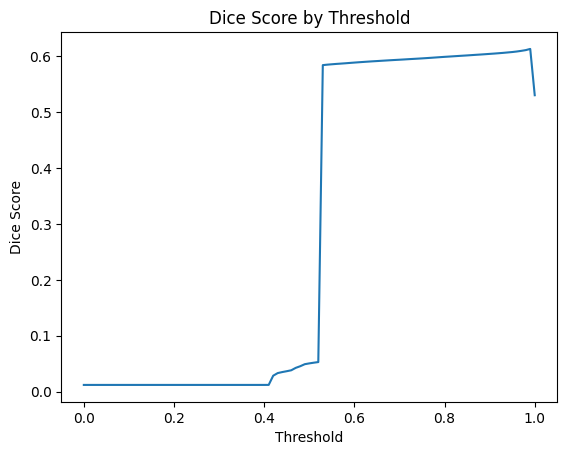

In [14]:
print("best dice score :", best_dice)
print("best threshold:", best_threshold)

plt.plot(values, dice_scores_by_threshold)
plt.xlabel("Threshold")
plt.ylabel("Dice Score")
plt.title("Dice Score by Threshold")
plt.show()

In [15]:
[x.numpy() for x in dice_scores_by_threshold]

[0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.01207139,
 0.012071533,
 0.012087132,
 0.012117538,
 0.02855917,
 0.033231884,
 0.03505486,
 0.036590062,
 0.038251765,
 0.042588625,
 0.04551482,
 0.04913144,
 0.050576795,
 0.05182176,
 0.052926842,
 0.5838387,
 0.5846579,
 0.58532876,
 0.5859829,
 0.5865381,
 0.5871199,
 0.5877535,
 0.5883704,
 0.58896023,
 0.5895246,
 0.5900712,
 0.5906065,
 0.5910824,
 0.5915889,
 0.59208167,
 0.592572,
 0.5930418,
 0.59348196,
 0.5939518,
 0.594454,
 0.5949213,
 0.59538645,
 0.5958655,
 0.5963844,
 0.5969294,

Best Predictions :

best 0 : 


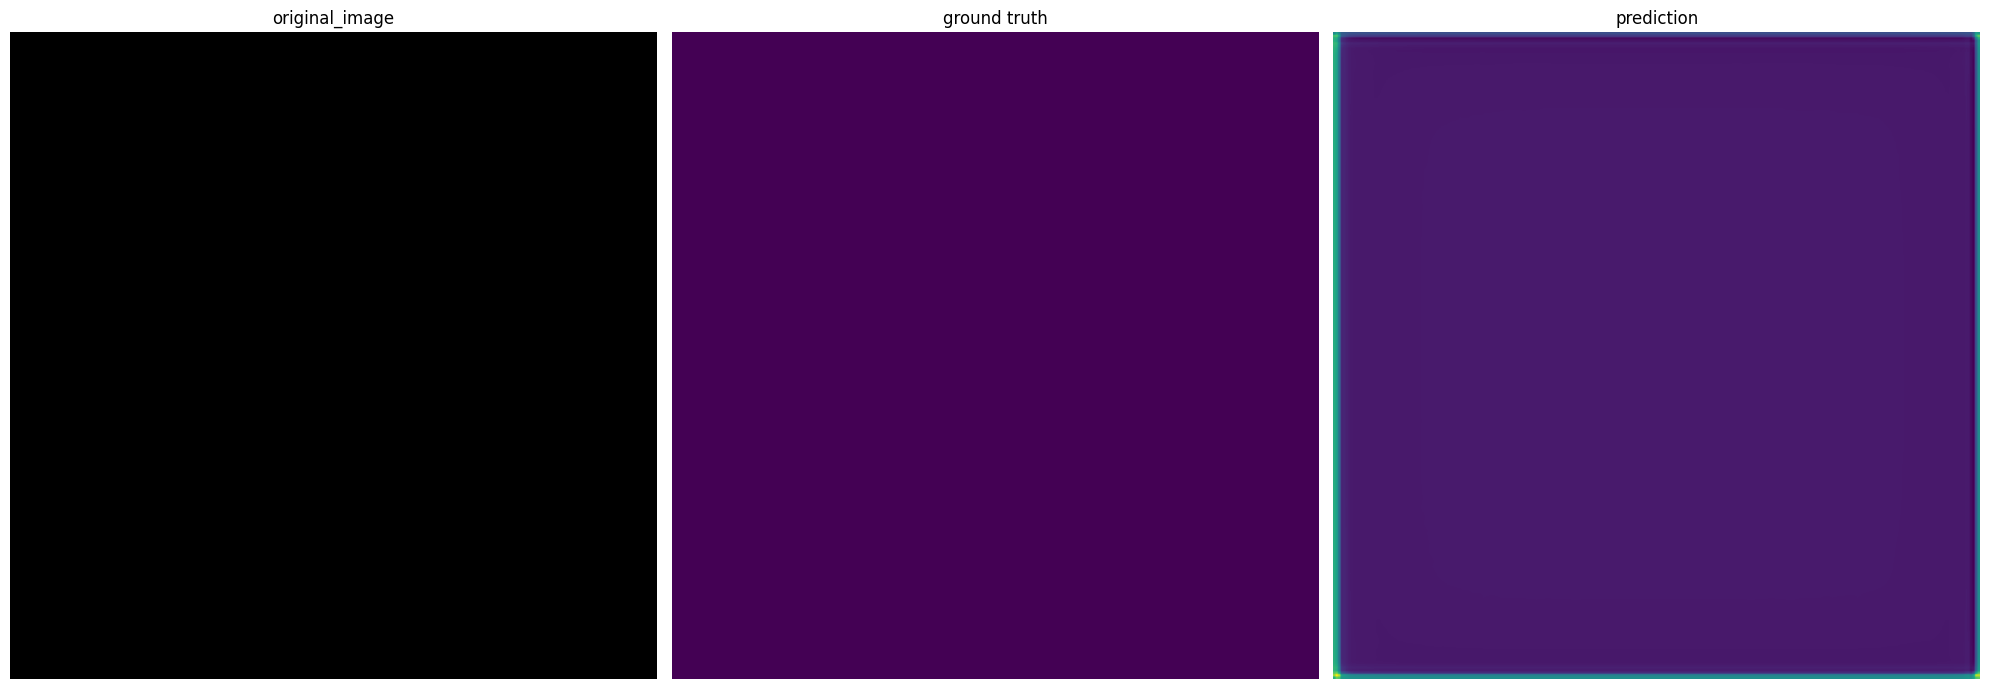

best 1 : 


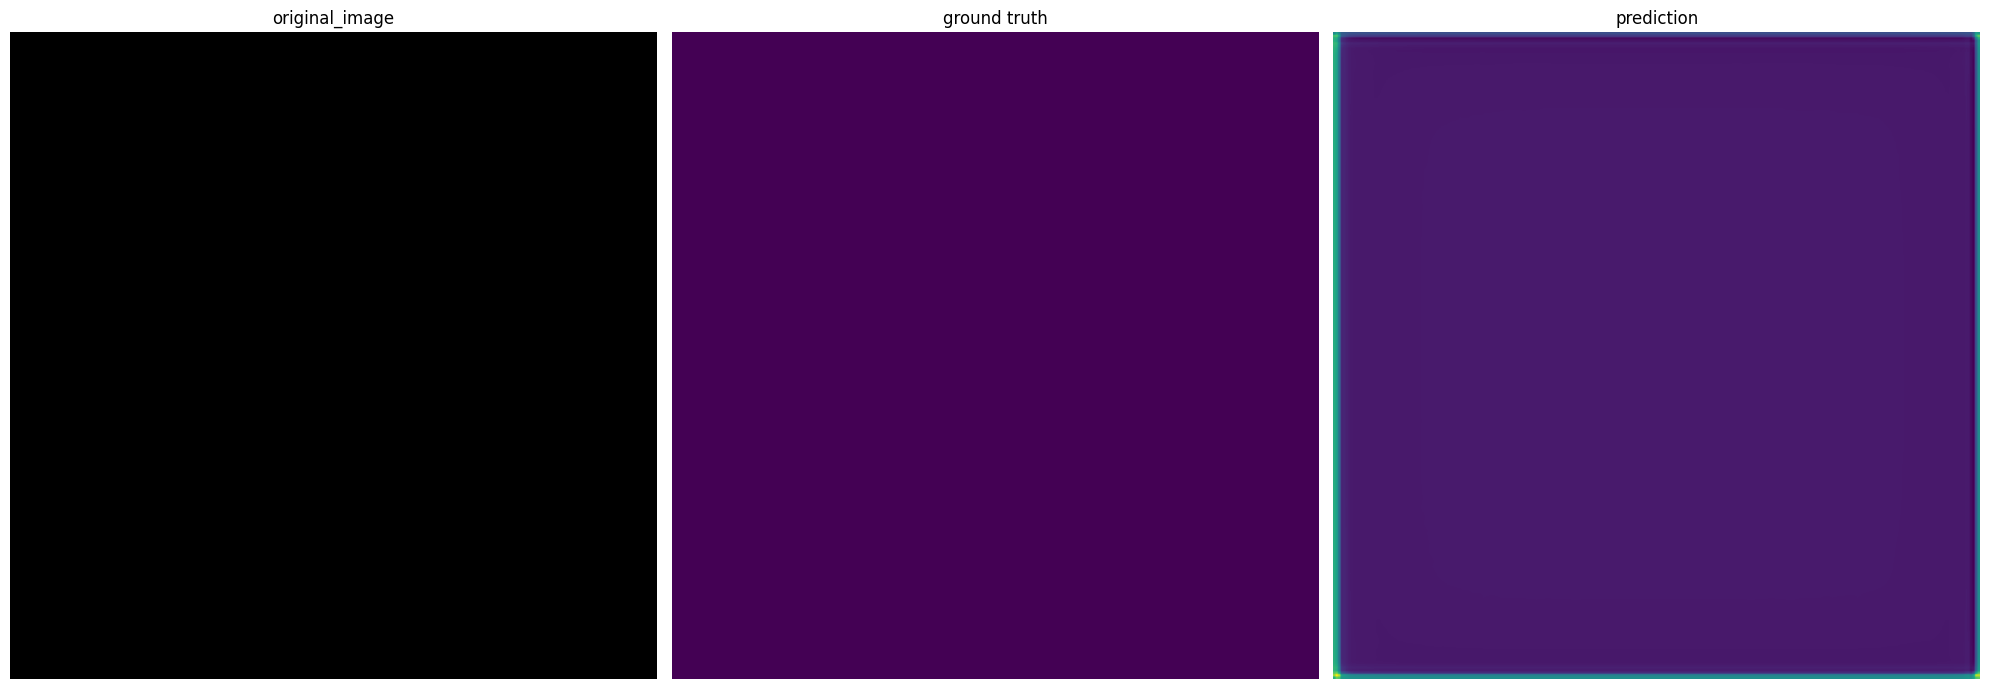

best 2 : 


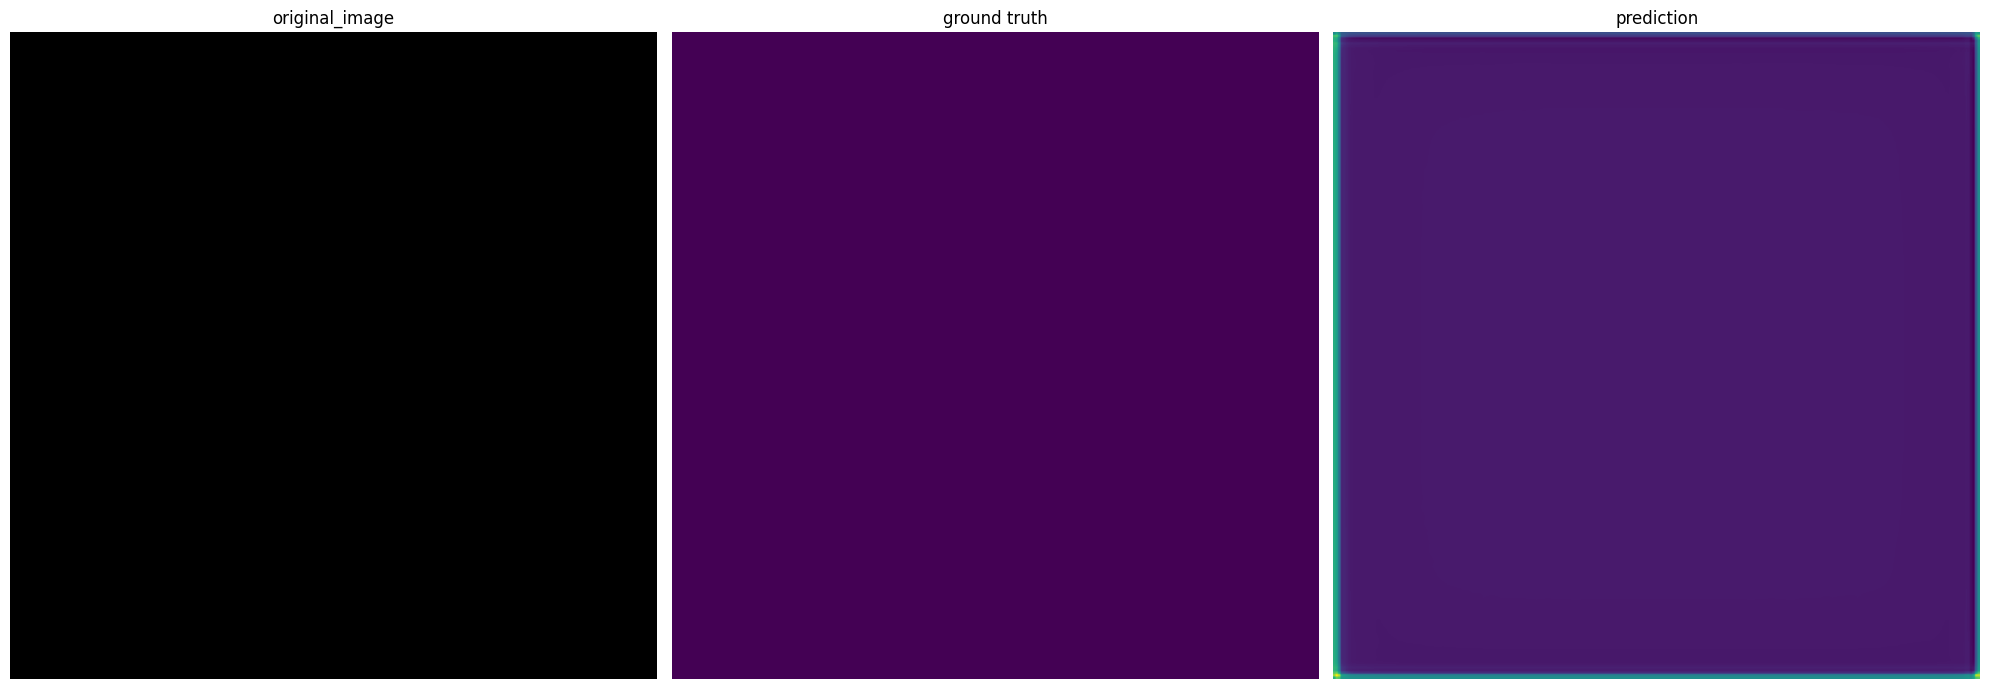

worst predictions :

worst 0 : 


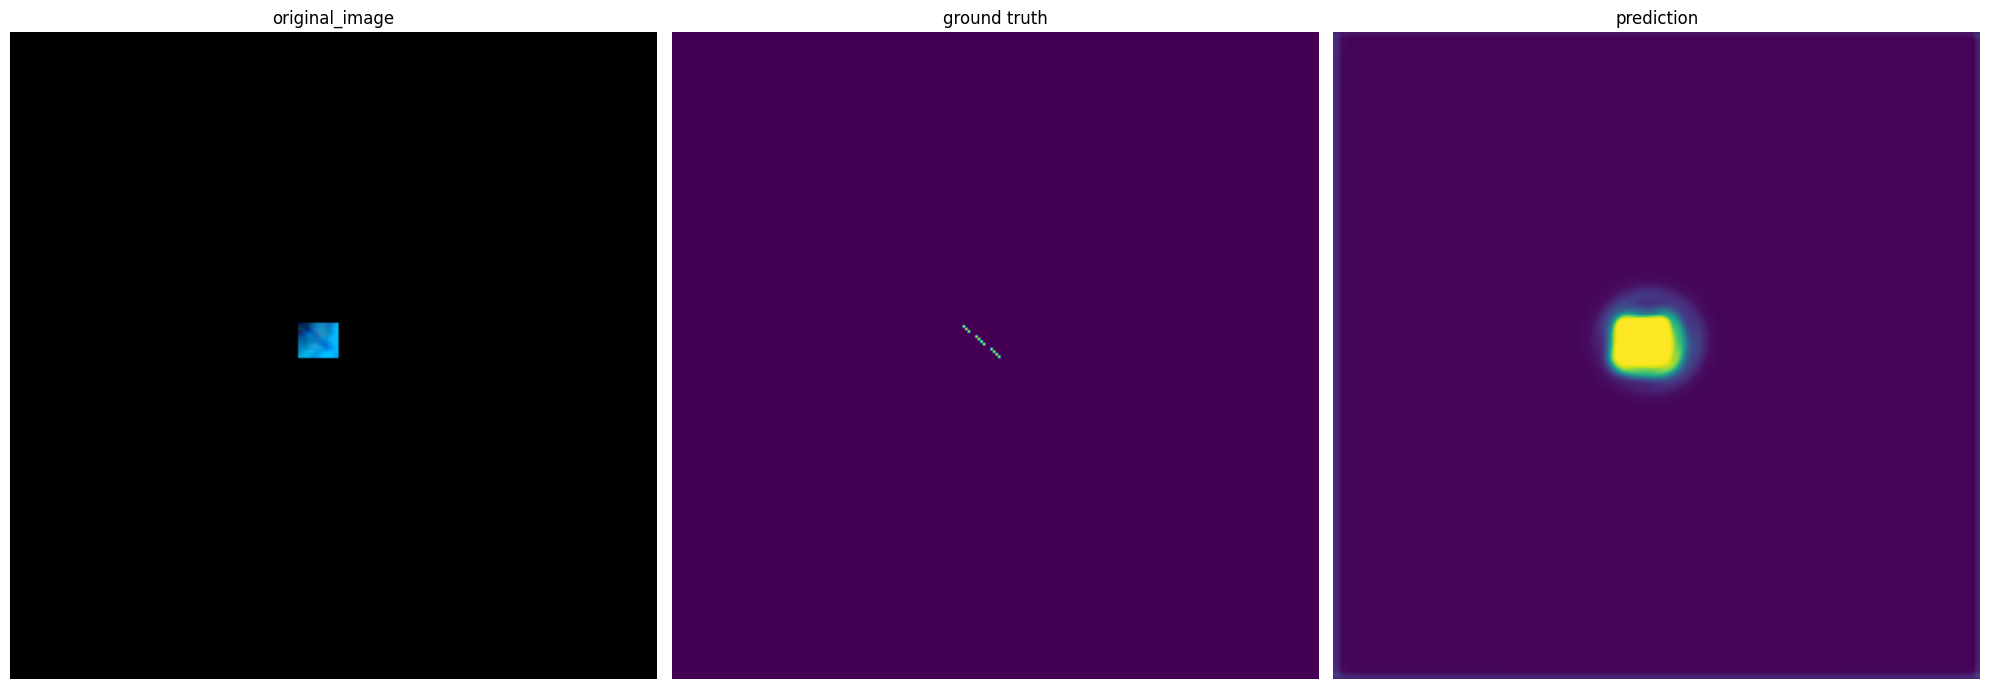

worst 1 : 


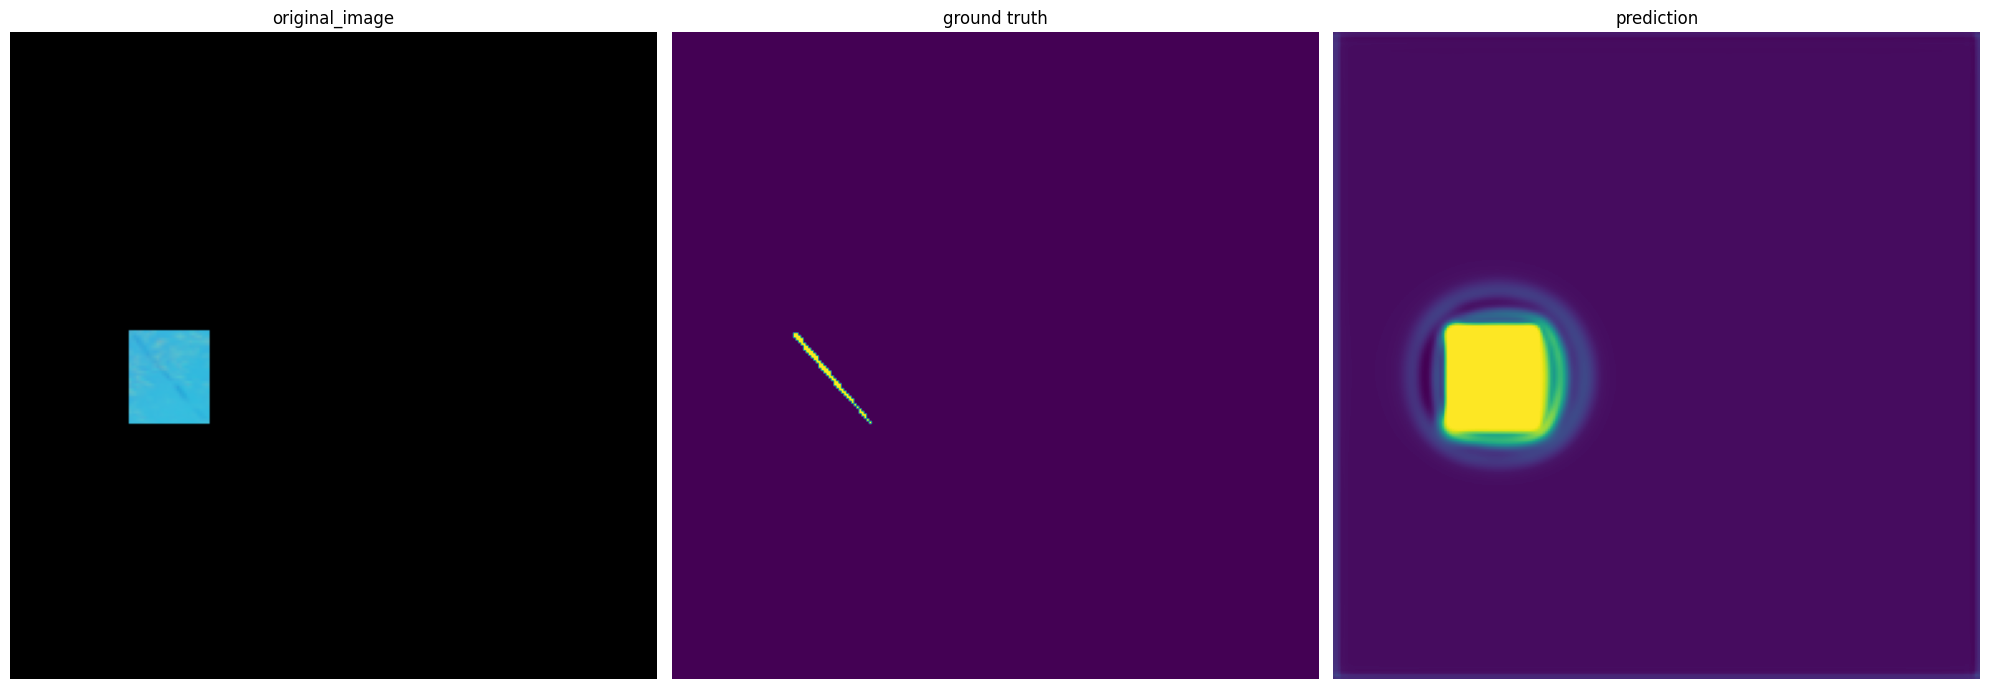

worst 2 : 


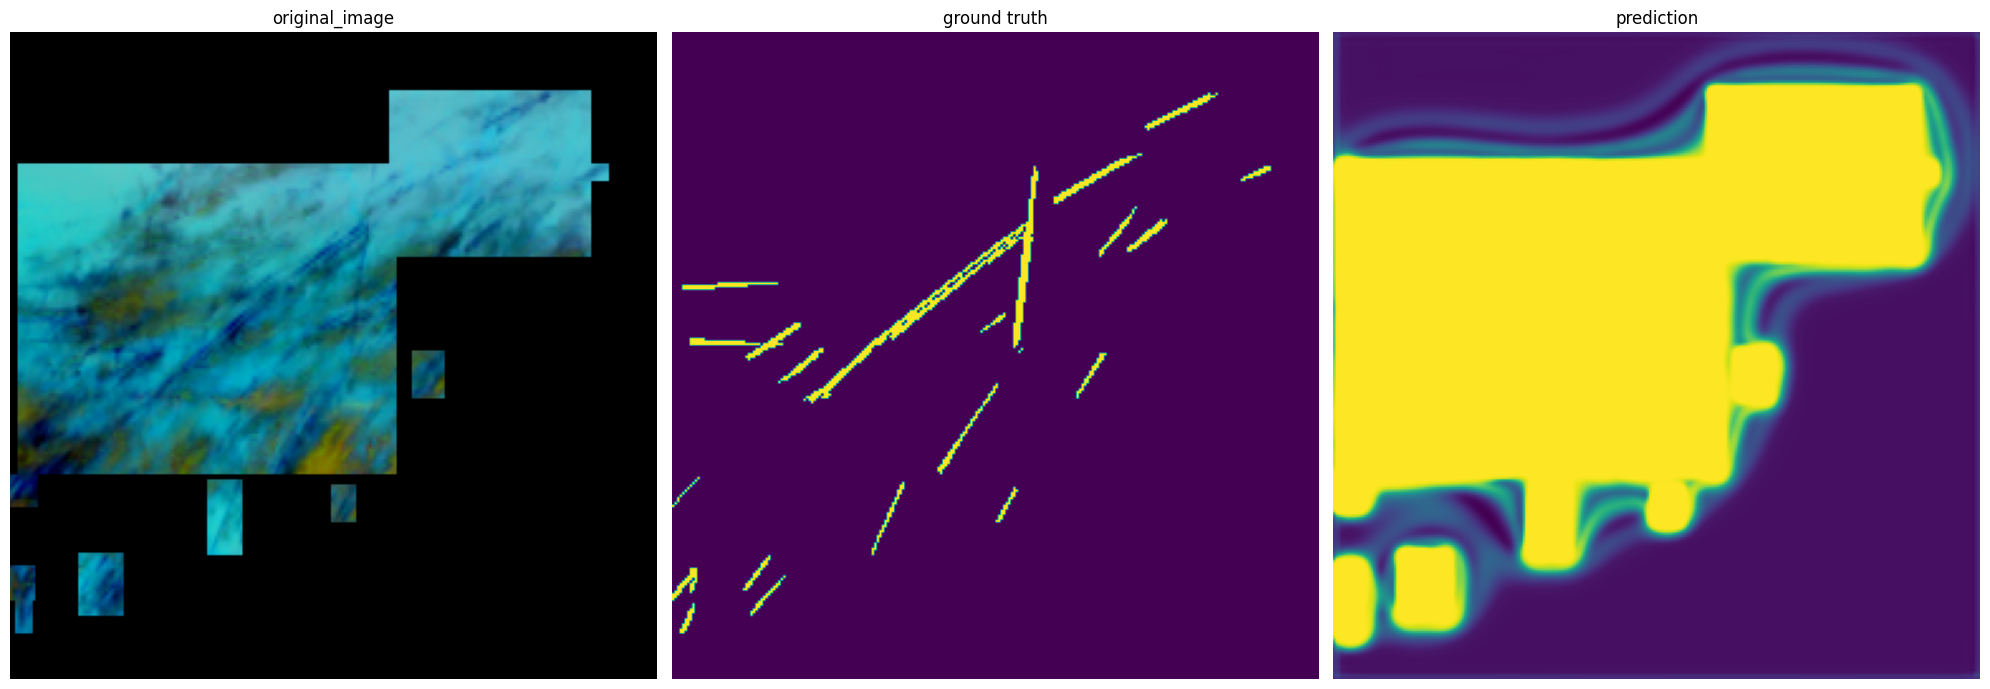

In [16]:
utils.show_predictions(original_images, ground_truths, predictions, best_threshold,0.001, 3)

1. treat batch normalization layer differently for train/val phases(Done!!)

2. sample train_valid set out of the train set and compute train_valid error and metric(dice score) as well as train_train error(Done!!)

3. plot errors(Done!!)

4. measure time, use pbar(Done!!)

5. add to the pipeline the code saving model checkpoints(Done!!)

6. tune threshold(Done!!)

7.  at inference stage, make a function that compares the prediction and the ground truth + outputs a data viz that compare them(Done!!)

8. Xavier initialization,cosine scheduler, device setting(Done!!)

9. use tensorboard to log losses and metrics.(Done!!)

10. data augmentation(Done!!)

11. tensor flow hyperparam optimization tool?(Later)